# PRACTICA 1 - APRENENTATGE COMPUTACIONAL
Integrants: Álvaro Díaz 1639484, Jan Planas 1636492, David Fuentes 1637892

## ANÀLISIS TITANIC


In [47]:
import numpy as np
import pandas as pd
from time import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve, roc_auc_score, auc, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, classification_report, average_precision_score

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [48]:
combined = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")
combined['Split'] = 'train'
titanic_test['Split'] = 'test'
combined = pd.concat([combined, titanic_test], ignore_index=True)
combined.info()
print()
print(f"El shape del train-data es {combined.shape}.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Split        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB

El shape del train-data es (1309, 13).


In [49]:
y_test = pd.read_csv('gender_submission.csv')

In [50]:
y_test = y_test['Survived']
y_test

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64

In [51]:
combined['cabin_letter'] = combined.Cabin.apply(lambda x: str(x)[0])
pd.pivot_table(combined,index='Pclass',columns='cabin_letter', values = 'Name', aggfunc='count')

cabin_letter,A,B,C,D,E,F,G,T,n
Pclass,,,,,,,,,
1,22.0,65.0,94.0,40.0,34.0,NaN,NaN,1.0,67.0
2,NaN,NaN,NaN,6.0,4.0,13.0,NaN,NaN,254.0
3,NaN,NaN,NaN,NaN,3.0,8.0,5.0,NaN,693.0


In [52]:
import random
def agregar_probabilidades_planta(dataframe):
    def asignar_planta(row):
        if row['cabin_letter'] != 'n':
            return ord(str(row['cabin_letter'])) - 64
        pclass = row['Pclass']
        if pclass == 1:
            return random.choices([1, 2, 3, 4, 5], weights=[0.05, 0.3, 0.4, 0.15, 0.1])[0]
        elif pclass == 2:
            return random.choices([3, 4, 5, 6], weights=[0.2, 0.3, 0.3, 0.2])[0]
        elif pclass == 3:
            return random.choices([5, 6, 7], weights=[0.2, 0.4, 0.4])[0]

    dataframe['Floor'] = dataframe.apply(asignar_planta, axis=1)
    
    return dataframe

combined['cabin_letter'] = combined.Cabin.apply(lambda x: str(x)[0])

combined = agregar_probabilidades_planta(combined)
#combined = combined[combined['Floor'] != 20]

print(combined.isna().sum())
pd.pivot_table(combined, index = 'Pclass', columns = 'Floor', values = 'Ticket' ,aggfunc ='count')

PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age              263
SibSp              0
Parch              0
Ticket             0
Fare               1
Cabin           1014
Embarked           2
Split              0
cabin_letter       0
Floor              0
dtype: int64


Floor,1,2,3,4,5,6,7,20
Pclass,,,,,,,,
1,25.0,86.0,119.0,48.0,44.0,NaN,NaN,1.0
2,NaN,NaN,46.0,74.0,88.0,69.0,NaN,NaN
3,NaN,NaN,NaN,NaN,145.0,278.0,286.0,NaN


In [53]:
combined = combined.drop(['Cabin', 'cabin_letter'], axis = 1)
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  Split        1309 non-null   object 
 12  Floor        1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


In [54]:
combined.loc[combined['Embarked'].isna(), 'Embarked'] = 'S'
print(combined.isna().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Embarked         0
Split            0
Floor            0
dtype: int64


In [55]:
combined['name_title'] = combined.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
nan_counts_by_title = combined.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title

name_title
Capt              0
Col               0
Don               0
Dona              0
Dr                1
Jonkheer          0
Lady              0
Major             0
Master            8
Miss             50
Mlle              0
Mme               0
Mr              176
Mrs              27
Ms                1
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

In [56]:
media_por_name_title = combined.groupby('name_title')['Age'].agg(['mean', 'std','count'])
media_por_name_title

,mean,std,count
name_title,,,
Capt,70.000000,NaN,1
Col,54.000000,5.477226,4
Don,40.000000,NaN,1
Dona,39.000000,NaN,1
Dr,43.571429,11.731115,7
Jonkheer,38.000000,NaN,1
Lady,48.000000,NaN,1
Major,48.500000,4.949747,2
Master,5.482642,4.161554,53


In [57]:
def agregar_probabilidades_edad(dataframe, media_por_name_title):
    def asignar_edad(row):
        if pd.isna(row['Age']) == True and row['name_title'] != 'Mr':
            return round(media_por_name_title['mean'][row['name_title']])
        return row['Age']

    dataframe['Age'] = dataframe.apply(asignar_edad, axis=1)

    return dataframe

combined = agregar_probabilidades_edad(combined, media_por_name_title)

nan_counts_by_title = combined.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title


name_title
Capt              0
Col               0
Don               0
Dona              0
Dr                0
Jonkheer          0
Lady              0
Major             0
Master            0
Miss              0
Mlle              0
Mme               0
Mr              176
Mrs               0
Ms                0
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

In [58]:
combined['Numerical_ticket'] = combined.Ticket.apply(lambda x: 1 if x.isdigit() else 0)
pd.pivot_table(combined,index='Numerical_ticket',columns='Survived', values = 'Ticket', aggfunc='count')

Survived,0.0,1.0
Numerical_ticket,,
0,142,88
1,407,254


In [59]:
combined = combined.drop(['Ticket', 'Name', 'PassengerId', 'Numerical_ticket'], axis=1)

In [60]:
combined.loc[combined['Fare'].isna(), 'Fare'] = 13.302889
print(combined.isna().sum())

Survived      418
Pclass          0
Sex             0
Age           176
SibSp           0
Parch           0
Fare            0
Embarked        0
Split           0
Floor           0
name_title      0
dtype: int64


In [61]:
combined['Fare_norm'] = np.log1p(combined.Fare)
combined['Parch_norm'] = np.log1p(combined.Parch)
combined['Sibsp_norm'] = np.log1p(combined.SibSp)
combined['Age_norm'] = combined.Age

In [62]:
scaler = MinMaxScaler()
combined[['Age_norm', 'Sibsp_norm', 'Fare_norm', 'Parch_norm']] = scaler.fit_transform(combined[['Age_norm', 'Sibsp_norm', 'Fare_norm', 'Parch_norm']])
combined.isna().sum()

Survived      418
Pclass          0
Sex             0
Age           176
SibSp           0
Parch           0
Fare            0
Embarked        0
Split           0
Floor           0
name_title      0
Fare_norm       0
Parch_norm      0
Sibsp_norm      0
Age_norm      176
dtype: int64

In [63]:
combined = combined.drop(['Age','SibSp', 'Parch', 'Fare'], axis=1)

In [64]:
combined

,Survived,Pclass,Sex,Embarked,Split,Floor,name_title,Fare_norm,Parch_norm,Sibsp_norm,Age_norm
0,0.0,3,male,S,train,7,Mr,0.338125,0.00000,0.315465,0.273456
1,1.0,1,female,C,train,3,Mrs,0.685892,0.00000,0.315465,0.473882
2,1.0,3,female,S,train,6,Miss,0.350727,0.00000,0.000000,0.323563
3,1.0,1,female,S,train,3,Mrs,0.639463,0.00000,0.315465,0.436302
4,0.0,3,male,S,train,5,Mr,0.352955,0.00000,0.000000,0.436302
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,S,test,6,Mr,0.352955,0.00000,0.000000,NaN
1305,NaN,1,female,C,test,3,Dona,0.753026,0.00000,0.000000,0.486409
1306,NaN,3,male,S,test,6,Mr,0.338125,0.00000,0.000000,0.480145
1307,NaN,3,male,S,test,6,Mr,0.352955,0.00000,0.000000,NaN


In [65]:
categorical_attributes = ['name_title', 'Embarked', 'Sex', 'Floor', 'Pclass']

for attribute in categorical_attributes:
    encoder = OneHotEncoder(sparse=False)
    attribute_encoded = encoder.fit_transform(combined[[attribute]])

    new_column_names = encoder.get_feature_names_out(input_features=[attribute])
    encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=combined.index)

    combined = combined.drop([attribute], axis=1)
    combined = pd.concat([combined, encoded_df], axis=1)

combined

,Survived,Split,Fare_norm,Parch_norm,Sibsp_norm,Age_norm,name_title_Capt,name_title_Col,name_title_Don,name_title_Dona,...,Floor_2,Floor_3,Floor_4,Floor_5,Floor_6,Floor_7,Floor_20,Pclass_1,Pclass_2,Pclass_3
0,0.0,train,0.338125,0.00000,0.315465,0.273456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,train,0.685892,0.00000,0.315465,0.473882,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,train,0.350727,0.00000,0.000000,0.323563,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,train,0.639463,0.00000,0.315465,0.436302,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,train,0.352955,0.00000,0.000000,0.436302,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,test,0.352955,0.00000,0.000000,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1305,NaN,test,0.753026,0.00000,0.000000,0.486409,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1306,NaN,test,0.338125,0.00000,0.000000,0.480145,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1307,NaN,test,0.352955,0.00000,0.000000,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [66]:
imputer = KNNImputer(n_neighbors=5)
train_test_col = combined['Split']
combined = combined.drop(['Split'], axis=1)
X_imputed = imputer.fit_transform(combined)

combined = pd.DataFrame(X_imputed, columns=combined.columns)

In [67]:
combined_bo = combined
combined_bo['Split'] = train_test_col
print("Nombre de NaNs total al dataset: " ,combined.isna().sum().sum())

Nombre de NaNs total al dataset:  0


In [68]:
combined_bo

,Survived,Fare_norm,Parch_norm,Sibsp_norm,Age_norm,name_title_Capt,name_title_Col,name_title_Don,name_title_Dona,name_title_Dr,...,Floor_3,Floor_4,Floor_5,Floor_6,Floor_7,Floor_20,Pclass_1,Pclass_2,Pclass_3,Split
0,0.0,0.338125,0.00000,0.315465,0.273456,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,train
1,1.0,0.685892,0.00000,0.315465,0.473882,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,train
2,1.0,0.350727,0.00000,0.000000,0.323563,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,train
3,1.0,0.639463,0.00000,0.315465,0.436302,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,train
4,0.0,0.352955,0.00000,0.000000,0.436302,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.0,0.352955,0.00000,0.000000,0.349868,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,test
1305,1.0,0.753026,0.00000,0.000000,0.486409,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,test
1306,0.0,0.338125,0.00000,0.000000,0.480145,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,test
1307,0.0,0.352955,0.00000,0.000000,0.349868,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,test


In [69]:
train_df = combined_bo.loc[combined_bo['Split'] == 'train'].copy()
test_df = combined_bo.loc[combined_bo['Split'] == 'test'].copy()
train_df = train_df[train_df['Floor_20'] != 1]
print(train_df.shape, test_df.shape)

(890, 40) (418, 40)


In [70]:
train_df.drop(columns=['Split'], inplace=True)
test_df.drop(columns=['Split'], inplace=True)
train_df.drop(columns=['Floor_20'], inplace=True)
test_df.drop(columns=['Floor_20'], inplace=True)

In [71]:
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']
test_df = test_df.drop(['Survived'], axis=1)

F1-score del modelo: 0.8516096485
Accuracy del modelo: 0.8636363636
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       266
           1       0.82      0.80      0.81       152

    accuracy                           0.86       418
   macro avg       0.85      0.85      0.85       418
weighted avg       0.86      0.86      0.86       418



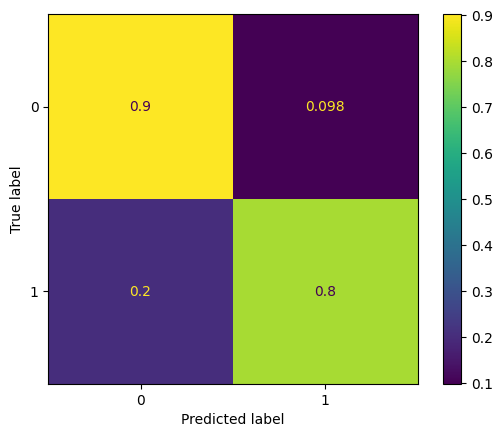

In [72]:
xgb_model = XGBClassifier(colsample_bytree= 0.9, gamma= 0.5, learning_rate= 0.1, max_depth= 5, min_child_weight= 0.01, n_estimators= 450, reg_alpha= 1, reg_lambda= 2, sampling_method= 'uniform', subsample= 0.55)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(test_df)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
confusion = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
report = classification_report(y_test, y_pred)
print(f'F1-score del modelo: {f1:.10f}')
print(f'Accuracy del modelo: {accuracy:.10f}')
print(report)